In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [38]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from pandas import Series, DataFrame
from pylab import rcParams

In [31]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [4]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## read data

In [5]:
address = 'titanic-training-data.csv'
titanic_training = pd.read_csv(address)
titanic_training.columns = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

titanic_training.head()
titanic_training.info()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## check for missing values

In [6]:
titanic_training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## drop columns not needed for predicting

In [7]:
titanic_data = titanic_training.drop(['Name', 'Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## fill missing values of `Age` with `mean`

In [8]:
titanic_data['Age'].mean()

29.69911764705882

In [9]:
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data['Age'].mean())

## fill missing valus of `Embarked` with most common value

In [11]:
titanic_data['Embarked'].mode()
titanic_data['Embarked'].mode()[0]

0    S
dtype: object

'S'

In [12]:
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(titanic_data['Embarked'].mode()[0])

## `Pclass` is categorical so convert it to `string`

In [13]:
titanic_data['Pclass'] = titanic_data['Pclass'].apply(str)

## review changes

In [15]:
titanic_data.head()
titanic_data.info()
titanic_data.isnull().sum()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

## one hot encoding of categorial features

In [16]:
titanic_data.dtypes

PassengerId      int64
Survived         int64
Pclass          object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object

In [17]:
titanic_data.dtypes[titanic_data.dtypes == 'object']

Pclass      object
Sex         object
Embarked    object
dtype: object

In [18]:
titanic_data.dtypes[titanic_data.dtypes == 'object'].index

Index(['Pclass', 'Sex', 'Embarked'], dtype='object')

In [19]:
for col in titanic_data.dtypes[titanic_data.dtypes == 'object'].index:
    for_dummy = titanic_data[col]
    titanic_data = pd.concat([titanic_data, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [20]:
titanic_data.head()
titanic_data.dtypes

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,male,22.0,1,0,7.2500,S,0,0,1,0,1,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,C,1,0,0,1,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,0,1,1,0,0,0,1
3,4,1,1,female,35.0,1,0,53.1000,S,1,0,0,1,0,0,0,1
4,5,0,3,male,35.0,0,0,8.0500,S,0,0,1,0,1,0,0,1


PassengerId      int64
Survived         int64
Pclass          object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Pclass_1         uint8
Pclass_2         uint8
Pclass_3         uint8
Sex_female       uint8
Sex_male         uint8
Embarked_C       uint8
Embarked_Q       uint8
Embarked_S       uint8
dtype: object

## define features and target

In [26]:
cols_exclude = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Embarked']
titanic_data.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype=object)

In [27]:
cols_feature = []
for col in titanic_data.columns.values:
    if col not in cols_exclude:
        cols_feature.append(col)

cols_feature

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [29]:
col_target = ['Survived']

## train - test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(titanic_data[cols_feature], 
                                                    titanic_data[col_target[0]], test_size=0.25)

## KNN classifier

In [32]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
model.get_params()

KNeighborsClassifier()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [34]:
y_pred = model.predict(X_test)

## performance

In [35]:
roc_curve(y_test, y_pred)

(array([0.        , 0.26277372, 1.        ]),
 array([0.        , 0.61627907, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [36]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
print(false_positive_rate)
print(true_positive_rate)
print(thresholds)

[0.         0.26277372 1.        ]
[0.         0.61627907 1.        ]
[2 1 0]


In [37]:
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6767526735698522

## vary k

In [41]:
neighbors = list(np.arange(1,30))
train_results = []
test_results = []

for n in neighbors:
   model = KNeighborsClassifier(n_neighbors=n)
   model.fit(X_train, y_train)
   
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

KNeighborsClassifier(n_neighbors=1)

KNeighborsClassifier(n_neighbors=2)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=4)

KNeighborsClassifier()

KNeighborsClassifier(n_neighbors=6)

KNeighborsClassifier(n_neighbors=7)

KNeighborsClassifier(n_neighbors=8)

KNeighborsClassifier(n_neighbors=9)

KNeighborsClassifier(n_neighbors=10)

KNeighborsClassifier(n_neighbors=11)

KNeighborsClassifier(n_neighbors=12)

KNeighborsClassifier(n_neighbors=13)

KNeighborsClassifier(n_neighbors=14)

KNeighborsClassifier(n_neighbors=15)

KNeighborsClassifier(n_neighbors=16)

KNeighborsClassifier(n_neighbors=17)

KNeighborsClassifier(n_neighbors=18)

KNeighborsClassifier(n_neighbors=19)

KNeighborsClassifier(n_neighbors=20)

KNeighborsClassifier(n_neighbors=21)

KNeighborsClassifier(n_neighbors=22)

KNeighborsClassifier(n_neighbors=23)

KNeighborsClassifier(n_neighbors=24)

KNeighborsClassifier(n_neighbors=25)

KNeighborsClassifier(n_neighbors=26)

KNeighborsClassifier(n_neighbors=27)

KNeighborsClassifier(n_neighbors=28)

KNeighborsClassifier(n_neighbors=29)

In [42]:
print(train_results)
print(test_results)

[0.9785725121359223, 0.7964009405339806, 0.8228724211165048, 0.7550819174757282, 0.7879816444174758, 0.7380916262135923, 0.765966322815534, 0.7327063106796117, 0.7630081917475728, 0.7168158373786409, 0.7242111650485437, 0.7143886529126214, 0.7261642900485437, 0.7151281856796118, 0.7224666262135923, 0.6965450546116505, 0.6995031856796117, 0.6926388046116505, 0.7019303701456311, 0.7016648968446602, 0.7026699029126214, 0.6894720873786409, 0.6995031856796117, 0.6960709951456311, 0.7038834951456312, 0.6721025485436893, 0.6750606796116505, 0.6694098907766991, 0.6774878640776699]
[0.6840519436428449, 0.6523934815820743, 0.6702597182142251, 0.6559158037684603, 0.6767526735698522, 0.6296893566457308, 0.6456459005262264, 0.6137328127652351, 0.630368358512986, 0.6203530809709726, 0.621711084705483, 0.6246817178747242, 0.6311746732303514, 0.6195467662536072, 0.621711084705483, 0.6094041758614835, 0.6152181293498558, 0.6050755389577321, 0.6094041758614835, 0.5897979969444916, 0.594126633848243, 0.5

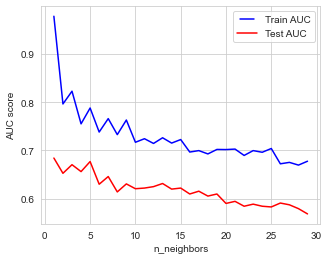

In [51]:
line1, = plt.plot(neighbors, train_results, color='b', label='Train AUC');
line2, = plt.plot(neighbors, test_results, color='r', label='Test AUC');

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score');
plt.xlabel('n_neighbors');
plt.show();

## parameter `p` for `L_p` distance
`p=1` is l1 (manhattan distance)   
`p=2` is l2 (euclidean distance)   
othe `p` is l_p (minkowski distance)

In [52]:
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []

for p in distances:
   model = KNeighborsClassifier(p=p)
   model.fit(X_train, y_train)
   
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

KNeighborsClassifier(p=1)

KNeighborsClassifier()

KNeighborsClassifier(p=3)

KNeighborsClassifier(p=4)

KNeighborsClassifier(p=5)

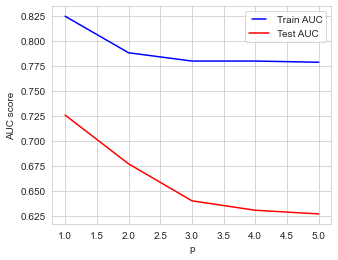

In [54]:
line1, = plt.plot(distances, train_results, color='b', label='Train AUC');
line2, = plt.plot(distances, test_results, color='r', label='Test AUC');

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score');
plt.xlabel('p');
plt.show();